In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import layers, models

In [2]:
df = '/kaggle/input/warp-waste-recycling-plant-dataset/Warp-C/train_crops'

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,          # Normalize pixel values to [0, 1]
    validation_split=0.2,     # Set aside 20% of data for validation
    rotation_range=20,        # Randomly rotate images
    width_shift_range=0.2,    # Randomly shift images horizontally
    height_shift_range=0.2,   # Randomly shift images vertically
    shear_range=0.2,          # Randomly shear images
    zoom_range=0.2,           # Randomly zoom in on images
    horizontal_flip=True,      # Randomly flip images
    fill_mode='nearest'        # Fill in new pixels created during transformation
)

In [4]:
train_generator = train_datagen.flow_from_directory(
    df,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',            
    seed=42                       
)

#  validation data
validation_generator = train_datagen.flow_from_directory(
    df,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=42
)
print(train_generator.class_indices)

Found 7061 images belonging to 5 classes.
Found 1762 images belonging to 5 classes.
{'bottle': 0, 'canister': 1, 'cans': 2, 'cardboard': 3, 'detergent': 4}


In [5]:
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
class_counts = np.bincount(train_generator.classes)

# Create a dictionary to map class names to counts
class_counts_dict = {class_names[i]: count for i, count in enumerate(class_counts)}

print(class_counts_dict)

{'bottle': 5216, 'canister': 120, 'cans': 450, 'cardboard': 520, 'detergent': 755}


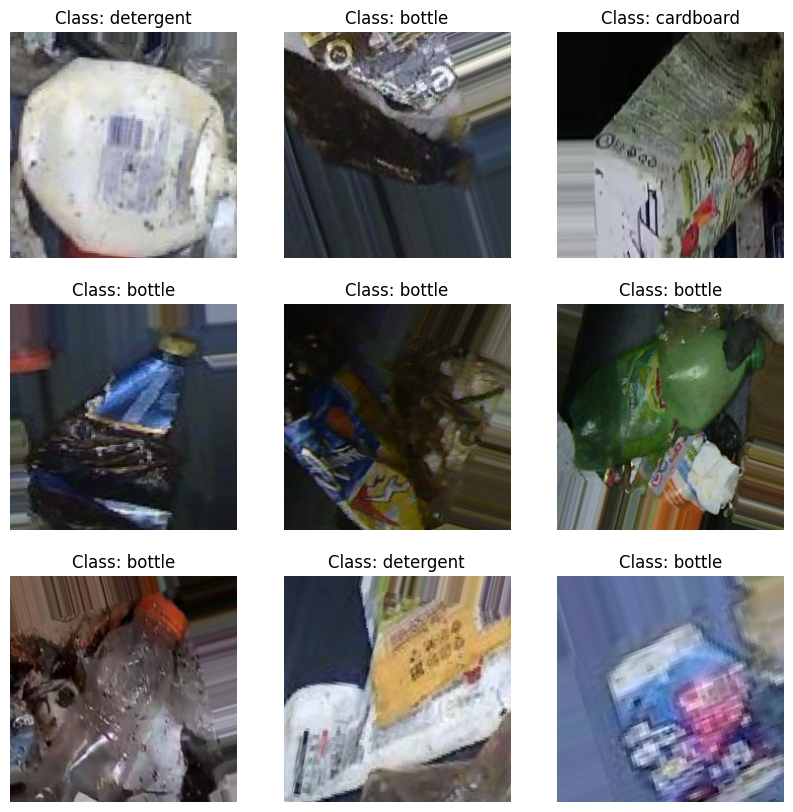

In [6]:
images, labels = next(train_generator)
class_labels = {v: k for k, v in train_generator.class_indices.items()}

plt.figure(figsize=(10, 10))
for i in range(9): 
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    
    class_index = np.argmax(labels[i])
    class_label = class_labels[class_index]
    
    plt.title("Class: {}".format(class_label))
    plt.axis('off') 

plt.show()

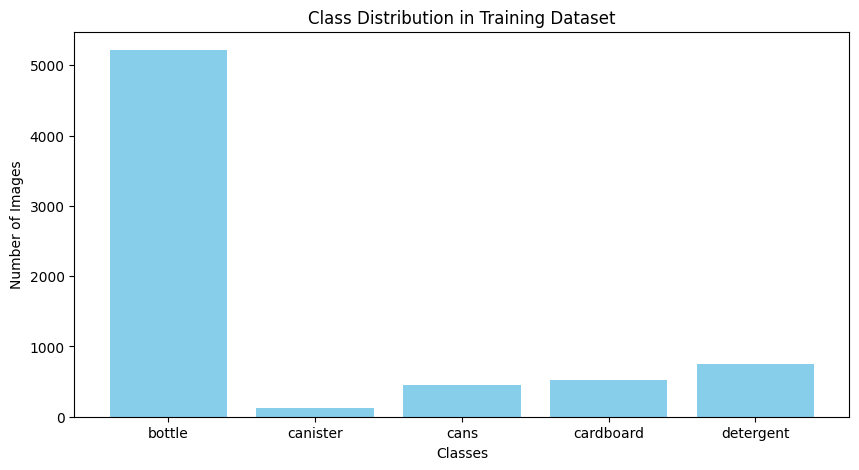

In [7]:
class_counts_dict = {class_names[i]: count for i, count in enumerate(class_counts)}

plt.figure(figsize=(10, 5))
plt.bar(class_counts_dict.keys(), class_counts_dict.values(), color='skyblue')
plt.xticks(list(train_generator.class_indices.values()), list(train_generator.class_indices.keys()))
plt.title('Class Distribution in Training Dataset')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.show()

In [8]:
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential()

    # Input Layer
    model.add(layers.Input(shape=input_shape))

    # First Convolutional Block
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Second Convolutional Block
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Third Convolutional Block
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Flatten the output before the dense layer
    model.add(layers.Flatten())
    
    # Dense Layers
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))

    # Output Layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model
input_shape = (224, 224, 3)
num_classes = len(train_generator.class_indices)

cnn_model = create_cnn_model(input_shape, num_classes)

In [9]:
# Compile the model
cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 220, 220, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 108, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 106, 106, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 49, 49, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    18,874,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,162,917 (73.10 MB)

 Trainable params: 19,162,917 (73.10 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = cnn_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=3,
    verbose=1
)

Epoch 1/3


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1730048572.092444      85 service.cc:145] XLA service 0x7c95f00021c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730048572.092520      85 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/221 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.3828 - loss: 1.9381 

I0000 00:00:1730048581.934639      85 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


221/221 ━━━━━━━━━━━━━━━━━━━━ 135s 544ms/step - accuracy: 0.7133 - loss: 0.9827 - val_accuracy: 0.7395 - val_loss: 0.8833
Epoch 2/3
221/221 ━━━━━━━━━━━━━━━━━━━━ 97s 426ms/step - accuracy: 0.7438 - loss: 0.7991 - val_accuracy: 0.7395 - val_loss: 0.8519
Epoch 3/3
221/221 ━━━━━━━━━━━━━━━━━━━━ 97s 427ms/step - accuracy: 0.7354 - loss: 0.8117 - val_accuracy: 0.7395 - val_loss: 0.8358


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


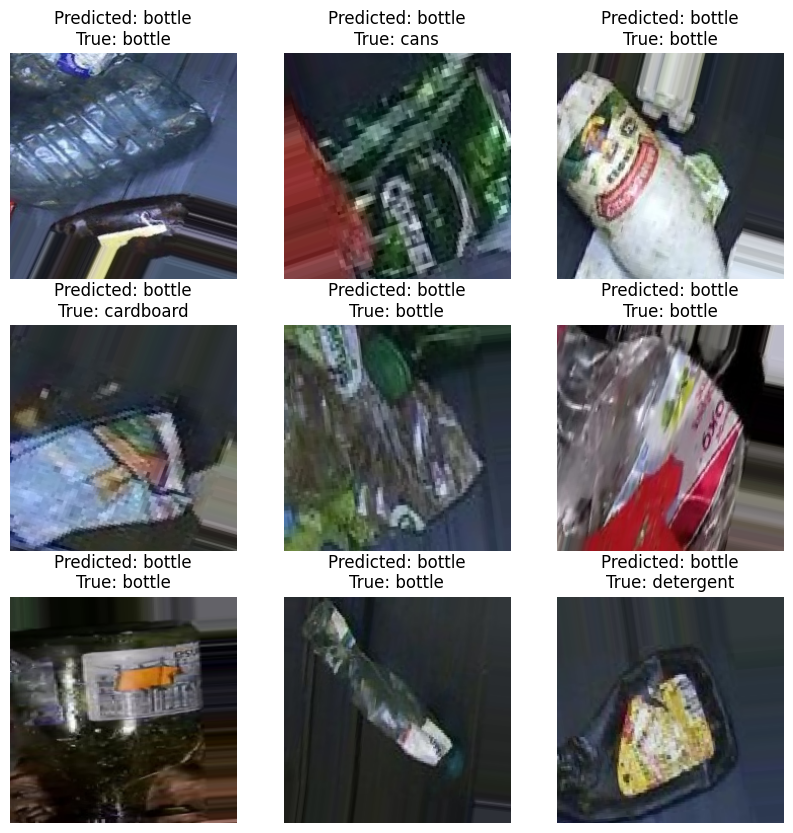

In [11]:
#### import numpy as np

images, labels = next(train_generator)
predictions = cnn_model.predict(images)

plt.figure(figsize=(10, 10))
for i in range(9):  
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    predicted_label = np.argmax(predictions[i])
    true_label = np.argmax(labels[i])
    plt.title(f"Predicted: {list(train_generator.class_indices.keys())[predicted_label]}\nTrue: {list(train_generator.class_indices.keys())[true_label]}")
    plt.axis('off')  # Turn off axis labels
plt.show()

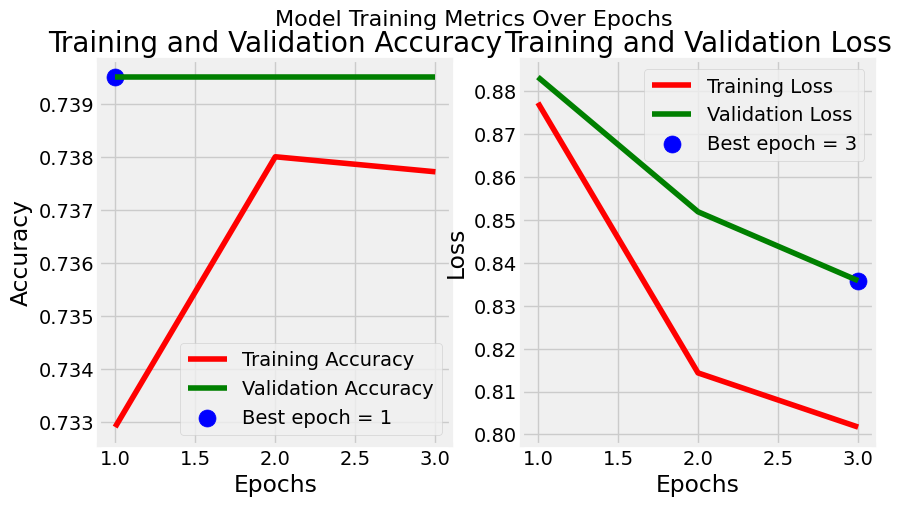

In [12]:
# Assuming 'hist' is the history object returned by model.fit()
tr_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
tr_loss = history.history['loss']
val_loss = history.history['val_loss']

# Find best epoch metrics
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

# Epochs for plotting
Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'

# Plotting
plt.figure(figsize=(10, 5))
plt.style.use('fivethirtyeight')

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_loss, 'r', label='Training Loss')
plt.plot(Epochs, val_loss, 'g', label='Validation Loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()